hello world 👋


In [5]:
import time
import warnings
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import optuna
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from scipy.stats import qmc
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [6]:
sns.set_theme(style="darkgrid")


warnings.filterwarnings("ignore", category=FutureWarning)
FIGSIZE = (12, 6)
N_TRIALS = 20

In [7]:
# fetch data set
ID = 1461
X, y = fetch_openml(data_id=ID, data_home=f"openml_download_{ID}", return_X_y=True)

# downsample and create a stratified train test split
X = X.sample(frac=0.2)
X = X.dropna(axis=0, how="any")
y = y.astype(int) - 1

y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [8]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=list(X.select_dtypes(include="category").columns),
)
train_pool.quantize()

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=list(X.select_dtypes(include="category").columns),
)
test_pool.quantize()

1. Tree parameters

   - Depth 1-15
   - Iterations 1-1024

2. Sampling parameters
   - Subsample 0.01 1.0
   - Colsample_bylevel 0.01 1.0
   - Sampling_frequency 0.01 1.0
3. Regularization parameters

   - Bagging_temperature 0.01 1000000
   - Reg_lambda 0.01 1.0

4. Learning rate
   - Learning_rate 1e-3 0.1
   - Model_shrink_rate 0.01 1.0
   - Model_shrink_mode Constand|Decreasing


- what are hyperparams, and why tune
- gridsearch, randomsearch, lhs search -> pro cons of each
- optuna in one go
- optuna in steps
- compare time should be less, for same or better performance


In [9]:
uni = np.random.uniform(0, 1, (100, 2))

sampler = qmc.LatinHypercube(d=2, optimization="lloyd")
lhs_sample = sampler.random(n=100)

Text(0.5, 1.0, 'latin hyper cube sampling')

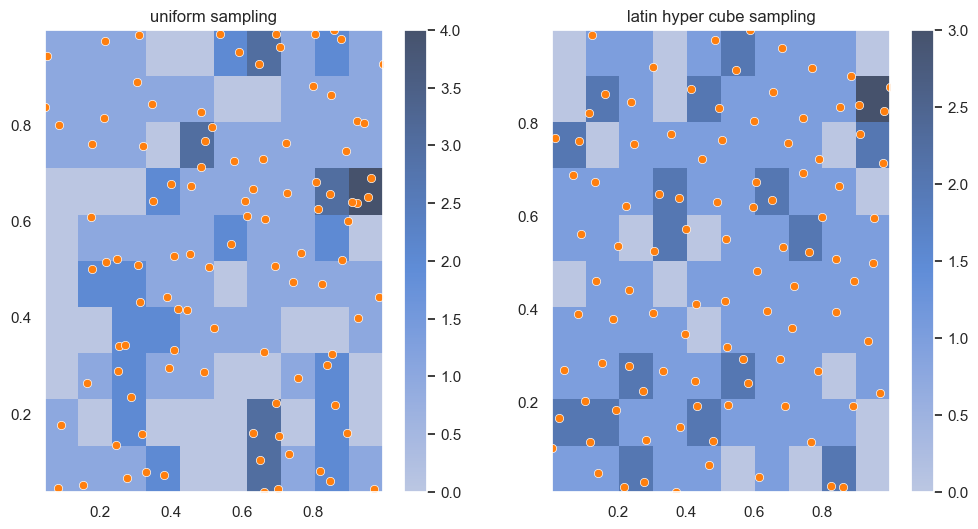

In [10]:
_, ax = plt.subplots(1, 2, figsize=FIGSIZE)


curr_ax = ax[0]
sns.histplot(x=uni[:, 0], y=uni[:, 1], bins=10, ax=curr_ax, cbar=True, thresh=None)
sns.scatterplot(x=uni[:, 0], y=uni[:, 1], ax=curr_ax, color="tab:orange")
curr_ax.set_title("uniform sampling")


curr_ax = ax[1]
sns.histplot(
    x=lhs_sample[:, 0], y=lhs_sample[:, 1], bins=10, ax=curr_ax, cbar=True, thresh=None
)
sns.scatterplot(x=lhs_sample[:, 0], y=lhs_sample[:, 1], ax=curr_ax, color="tab:orange")
curr_ax.set_title("latin hyper cube sampling")

In [15]:
sampler = qmc.LatinHypercube(d=2, optimization="lloyd")
sample = sampler.random(n=3)

l_bounds = [1, 1]
u_bounds = [15, 1024]
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

params = {
    "depth": sample_scaled[:, 0].astype(int),
    "iterations": sample_scaled[:, 1].astype(int),
}

model = CatBoostClassifier(loss_function="Logloss", verbose=16)

grid_search_result = model.grid_search(
    X=train_pool,
    param_grid=params,
    cv=2,
    stratified=True,
    refit=False,
)

0:	learn: 0.6560135	test: 0.6564940	best: 0.6564940 (0)	total: 20.7ms	remaining: 20.6s
16:	learn: 0.3700125	test: 0.3770111	best: 0.3770111 (16)	total: 123ms	remaining: 7.1s
32:	learn: 0.2779054	test: 0.2912008	best: 0.2912008 (32)	total: 214ms	remaining: 6.27s
48:	learn: 0.2404157	test: 0.2586509	best: 0.2586509 (48)	total: 416ms	remaining: 8.06s
64:	learn: 0.2221174	test: 0.2447332	best: 0.2447332 (64)	total: 551ms	remaining: 7.91s
80:	learn: 0.2095156	test: 0.2372406	best: 0.2372406 (80)	total: 671ms	remaining: 7.59s
96:	learn: 0.1988272	test: 0.2311434	best: 0.2311434 (96)	total: 787ms	remaining: 7.31s
112:	learn: 0.1904668	test: 0.2261746	best: 0.2261746 (112)	total: 925ms	remaining: 7.25s
128:	learn: 0.1837234	test: 0.2233126	best: 0.2233126 (128)	total: 1.04s	remaining: 6.99s
144:	learn: 0.1789507	test: 0.2215463	best: 0.2215083 (143)	total: 1.16s	remaining: 6.83s
160:	learn: 0.1740584	test: 0.2198989	best: 0.2198971 (159)	total: 1.27s	remaining: 6.61s
176:	learn: 0.1698512	test

In [16]:
grid_search_result["params"]

{'depth': 8, 'iterations': 998}

In [ ]:
def obj_step(trial, step: int, best_params: dict = {}) -> float:
    if step == 1:
        params = {
            "depth": trial.suggest_int(name="depth", low=1, high=15),
            "iterations": trial.suggest_int("iterations", 1, 1024),
        }
    elif step == 2:
        params = {
            "subsample": trial.suggest_float("subsample", 0.01, 1.0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
            "sampling_frequency": trial.suggest_float("sampling_frequency", 0.01, 1.0),
        }
    elif step == 3:
        params = {
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.01, 1),
            "bagging_temperature": trial.suggest_float(
                "bagging_temperature", 0.01, 1_000_000, log=True
            ),
        }
    elif step == 4:
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "model_shrink_rate": trial.suggest_int("iterations", 0.01, 1, log=True),
            "model_shrink_mode": trial.suggest_categorical(
                "model_shrink_mode", ["Constant", "Decreasing"]
            ),
        }

    params.update(best_params)

    cbc = CatBoostClassifier(
        **params,
        eval_metric="F1",
        # cat_features=list(X.select_dtypes(include="category").columns),
    )
    cbc.fit(train_pool, eval_set=(test_pool), verbose=False)

    return cbc.get_best_score().get("validation").get("F1")

In [ ]:
best_params, elapsed_time = {"iterations": 128}, []

for i in range(1, 5):
    start = time.time()
    obj_i = partial(obj_step, step=i, best_params=best_params)
    study = optuna.create_study(study_name="baby-steps", direction="maximize")
    study.optimize(obj_i, n_trials=N_TRIALS, timeout=120)

    end = time.time()
    elapsed_time.append(end - start)
    best_params.update(study.best_params)
    print("-" * 10)
    print(f"time step {i}: {elapsed_time[i-1]:.2f} sec")
    print(f"total time step : {np.sum(elapsed_time):.2f} sec")
    print(f"{best_params=}")
    print(f"{study.best_value=}")
    print("-" * 10)

In [ ]:
def obj_all(trial) -> float:
    params = {
        "depth": trial.suggest_int(name="depth", low=1, high=15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.01, 1),
        "bagging_temperature": trial.suggest_float(
            "bagging_temperature", 1e-3, 1_000_000, log=True
        ),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "iterations": trial.suggest_int("iterations", 1, 256),
    }

    cbc = CatBoostClassifier(
        **params,
        eval_metric="F1",
        # cat_features=list(X.select_dtypes(include="category").columns),
    )
    cbc.fit(train_pool, eval_set=(test_pool), verbose=False)

    return cbc.get_best_score().get("validation").get("F1")


print("-" * 10)

start = time.time()
study = optuna.create_study(study_name="all-in", direction="maximize")
study.optimize(obj_all, n_trials=4 * N_TRIALS, timeout=120)

end = time.time()
print("-" * 10)
print(f"time all-in: {end - start:.2f} sec")
print(f"{study.best_params=}")
print(f"{study.best_value=}")